# 1. Importações de bibliotecas e carregamento de dados

In [1]:
# Importando bibliotecas necessárias
import json
import numpy as np
import pandas as pd
import math
import sys
import os
import seaborn as sns
import tensorflow as tf
from numpy import zeros, array, asarray
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot
from matplotlib.pyplot import figure
from keras import metrics
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Activation
from keras.layers import Flatten
from keras.layers import Embedding

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


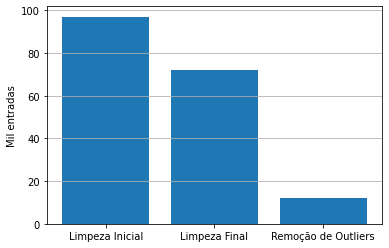

In [2]:
pyplot.ylabel("Mil entradas")
pyplot.bar(["Limpeza Inicial", "Limpeza Final", "Remoção de Outliers"], [97, 72, 12])
ax = pyplot.axes()
ax.yaxis.grid(True)
pyplot.show()

In [ ]:
# Parametros modificados com frequência
debug = True
col_switch = ('summary', 'description')
xcol = col_switch[1]
should_translate = False

# Esses são importantes
rstate = 7
docs_length = 'mean'
z_score_threshold = 1
z_score_times = 5
embedding_size = 128
emb_model_learning_rate = 0.005
wind = 10
mcount = 10
norm_vectors = True
lstm = True
dense_layers = False
dropout = True
dropout_default_value = 0.8100000000000005
opt_lr = 0.011
ctered = True
num_epochs = 100
batch_size = 128
validation_size = 0.25

In [ ]:
# Abrindo dados como ndarray
data = []
path = './drive/MyDrive/ColabNotebooks/data/'
filelist = os.listdir(path)
filelist.sort()
repo_num = len(filelist)
print("Numero de repositorios: {}".format(repo_num))
for filename in filelist:
  with open(path + filename, 'r') as file:
    repo = json.load(file)
    data += repo
ndata = pd.DataFrame(data).values
pd_data = pd.DataFrame(data)
if debug:
  print(ndata)
  print(ndata.shape)

Numero de repositorios: 70
[['14161' 'ABU'
  list(['contrib-graphic remove body attribute from example.json'])
  list(["i know it's a core model attribute but it's not actually used in this component so it's a little misleading to list it in example.json"])
  '1800' 96.0]
 ['14436' 'ABU' list(['remove readme.pdf'])
  list(["this pdf is hugely and no longer req'd"]) '120' 97.0]
 ['14201' 'ABU' list(['unused color variables'])
  list(['remove from colors.less file or use in theme']) '1800' 97.0]
 ...
 ['10102' 'ZONG' list(["andi's work in"]) nan '3589200' nan]
 ['10010' 'ZONG'
  list(['create diagrams showing the zong modules and their dependencies'])
  nan '9600' nan]
 ['10009' 'ZONG' list(['write guide how to build zong']) nan '11400' nan]]
(97274, 6)


In [ ]:
pd_data

,id,project,summary,description,timespent,alpha
0,14161,ABU,[contrib-graphic remove body attribute from ex...,[i know it's a core model attribute but it's n...,1800,96.0
1,14436,ABU,[remove readme.pdf],[this pdf is hugely and no longer req'd],120,97.0
2,14201,ABU,[unused color variables],[remove from colors.less file or use in theme],1800,97.0
3,11902,ABU,[review outstanding pull requests],[as per call on sven adding on aniket's behalf],93600,97.0
4,15601,ABU,[remove istrackable from adaptmodel.js],[as it isn't actually implemented also remove ...,900,98.0
...,...,...,...,...,...,...
97269,10104,ZONG,[andi's work in],NaN,1681200,NaN
97270,10103,ZONG,[andi's work in],NaN,1008000,NaN
97271,10102,ZONG,[andi's work in],NaN,3589200,NaN
97272,10010,ZONG,[create diagrams showing the zong modules and ...,NaN,9600,NaN


In [ ]:
# Funções auxiliares
def print_all(df):
  with pd.option_context('display.max_rows', None):
    print(df)

def my_zscore(x):
  return ((x - x.mean())/x.std())

# 2. Limpeza dos dados

In [ ]:
# Removendo linhas com description null
bool_series = pd.notnull(pd_data['description']) 
pd_data = pd_data[bool_series]

nan_value = float("NaN")

pd_data.replace("", nan_value, inplace=True)
pd_data.replace(" ", nan_value, inplace=True)
pd_data.replace("nan", nan_value, inplace=True)

pd_data.dropna(subset = ["description"], inplace=True)

# Removendo linhas com summary null
bool_series = pd.notnull(pd_data['summary']) 
pd_data = pd_data[bool_series]

# Removendo linhas com timespent null
bool_series = pd.notnull(pd_data['timespent']) 
pd_data = pd_data[bool_series]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
# Funções para realizar limpeza nos textos
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def id_removes(text):
  return re.sub('\[(\w|\W)*\]', '', text)

def link_removes(text):
  return re.sub('(http:|https:)\/\/(\w+|\W+\.\w+\W+(\.\w+\W+)*)(\/\w+|\W+|\w+)*', '', text)

def remove_stop_words(text):
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  return ' '.join(filtered_sentence)

def stemming(text):
  ps = PorterStemmer()
  words = word_tokenize(text)
  stemmed_sentence = [ps.stem(w) for w in words]
  return ' '.join(stemmed_sentence)

def lemmatize(text):
  words = word_tokenize(text)
  le = WordNetLemmatizer()
  lemmatized_sentence = [le.lemmatize(w) for w in words]
  return ' '.join(lemmatized_sentence)

def num_remove(text):
  word_tokens = word_tokenize(text)
  non_num_seq = []
  for word in word_tokens:
    if re.match('\d+', word):
      non_num_seq.append(re.sub('\d+', '', word))
    else:
      non_num_seq.append(word)
  return ' '.join(non_num_seq)

def len_cut(text):
  word_tokens = word_tokenize(text)
  cutted = [w for w in word_tokens if not len(w) == 1]
  return ' '.join(cutted)

def list_to_str(text_list):
  sentence_agg = ''
  for item in text_list:
    sentence_agg += item
    sentence_agg += ' '
  return sentence_agg.rstrip()

def clean_str(my_str):
  clean_list = ["'", "(", ")"]
  space_list = [".", "-", "/", "#", ":", "<", ">", "_", "[", "]", "+", "{", "}", "!", "@", "$", "%", "*", "=", "…", "?", "`", ",", "\r", "\n", "\d", '"', "~", "^", "PR", "|", "&"]
  for ccrt in clean_list:
    if(ccrt in my_str):
      my_str = my_str.replace(ccrt,"")  
  for scrt in space_list:
    if(scrt in my_str):
      my_str = my_str.replace(scrt," ")
  return my_str.lower()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Aplicando funções de limpeza textual
resumo = pd_data['summary'].apply(list_to_str) 
resumo = resumo.apply(id_removes)  
resumo = resumo.apply(clean_str)
resumo = resumo.apply(remove_stop_words)
resumo = resumo.apply(lemmatize)
# resumo = resumo.apply(stemming)
resumo = resumo.apply(num_remove)
resumo = resumo.apply(len_cut)
resumo.replace('', np.nan, inplace=True)
resumo.astype(str)

tempo = pd_data['timespent']

descricao = pd_data['description'].apply(list_to_str)  
descricao = descricao.apply(id_removes)
descricao = descricao.apply(link_removes)
descricao = descricao.apply(clean_str)
descricao = descricao.apply(remove_stop_words)
descricao = descricao.apply(lemmatize)
# descricao = descricao.apply(stemming)
descricao = descricao.apply(num_remove)
descricao = descricao.apply(len_cut)
descricao.replace('', np.nan, inplace=True)

In [ ]:
# Recriando o dataset somente com as colunas necessárias
pd_data = pd.DataFrame()
pd_data['summary'] = resumo
pd_data['description'] = descricao
pd_data['timespent'] = tempo

In [ ]:
# Convertendo o timespent para float
pd_data['timespent'] = pd_data.timespent.astype(float)

# Removendo linhas com description null
bool_series = pd.notnull(pd_data['description']) 
pd_data = pd_data[bool_series]

nan_value = float("NaN")

pd_data.replace("", nan_value, inplace=True)
pd_data.replace(" ", nan_value, inplace=True)
pd_data.replace("nan", nan_value, inplace=True)

pd_data.dropna(subset = ["description"], inplace=True)

# Removendo linhas com summary null
bool_series = pd.notnull(pd_data['summary']) 
pd_data = pd_data[bool_series]

# Removendo linhas com timespent null
bool_series = pd.notnull(pd_data['timespent']) 
pd_data = pd_data[bool_series]

In [ ]:
pd_data

,summary,description,timespent
0,contrib graphic remove body attribute example ...,know core model attribute actually used compon...,1800.0
1,remove readme pdf,pdf hugely longer reqd,120.0
2,unused color variable,remove color le file use theme,1800.0
3,review outstanding pull request,per call sven adding anikets behalf,93600.0
4,remove istrackable adaptmodel,isnt actually implemented also remove reference,900.0
...,...,...,...
97249,clean,merge move test project test,3600.0
97250,java se implementation xmlreader xmlwriter,create java se implementation platform indepen...,7200.0
97251,clean utils,get rid integrate far possible move pdlib coll...,14400.0
97252,java se dependency project,clean utils project java se dependency move ja...,8100.0


# 3. Remoção inicial de outliers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


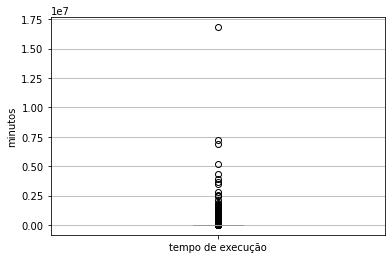

In [ ]:
#Antes da limpeza dos outliers
pyplot.boxplot(x=pd_data['timespent'], labels=['tempo de execução'])
pyplot.ylabel('minutos')
ax = pyplot.axes()        
ax.yaxis.grid(True)
pyplot.show()

In [ ]:
# Aplicando o zscore para remoção dos outliers
cara =  my_zscore(pd_data['timespent'])
df_sem_outlier_z = pd.DataFrame(
    pd_data[(abs(cara) < z_score_threshold)])

for i in range(z_score_times):
  cara =  my_zscore(df_sem_outlier_z['timespent'])
  df_sem_outlier_z = pd.DataFrame(
      df_sem_outlier_z[(abs(cara) < z_score_threshold)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


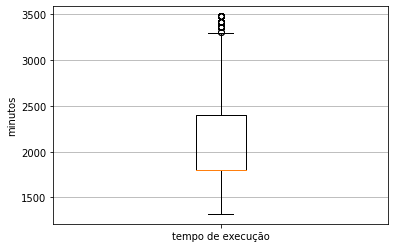

In [ ]:
#Pós limpeza dos outliers
pyplot.boxplot(x=df_sem_outlier_z['timespent'], labels=['tempo de execução'])
pyplot.ylabel('minutos')
ax = pyplot.axes()        
ax.yaxis.grid(True)
pyplot.show()

In [ ]:
df_sem_outlier_z.hist('timespent')

In [ ]:
df_sem_outlier_z

In [ ]:
data = df_sem_outlier_z

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./drive/MyDrive/ColabNotebooks/mlsdee-1584025432698-0d10d20cb49c.json"
print(os.environ['GOOGLE_APPLICATION_CREDENTIALS'])

In [ ]:
# Função para tradução
from google.cloud import translate_v3beta1 as translate

def translate_text(text="YOUR_TEXT_TO_TRANSLATE", src_lang='pt', project_id="YOUR_PROJECT_ID"):
    """Translating Text."""

    client = translate.TranslationServiceClient()

    location = "global"

    parent = f"projects/{project_id}/locations/{location}"

    response = client.translate_text(parent=parent,
            contents=[text],
            mime_type="text/plain",
            source_language_code=src_lang,
            target_language_code="en-US"
    )

    return response.translations[0].translated_text

def detect_language(text="YOUR_TEXT_TO_DETECT", project_id="YOUR_PROJECT_ID"):
    """Detecting the language of a text string."""

    client = translate.TranslationServiceClient()

    location = "global"

    parent = f"projects/{project_id}/locations/{location}"

    response = client.detect_language(
        content=text,
        parent=parent,
        mime_type="text/plain"
    )

    return response.languages[0].language_code

In [ ]:
# Traduzir tudo para o inglês
translated_count = 0

def detect_and_translate(text):
  global translated_count

  detected = detect_language(text, 'mlsdee-1584025432698')

  if detected == 'en' or detected == 'en-US' or detected == 'und':
    return text

  translated_count += 1
  print(translated_count)
  print(detected)
  print(text)
  result = translate_text(text, detected, 'mlsdee-1584025432698')
  print(result)
  return result


In [ ]:
if should_translate:
  data['summary'] = data['summary'].apply(detect_and_translate)
  data['description'] = data['description'].apply(detect_and_translate)
  data.to_csv('data.csv', index=False)

In [ ]:
# Garantir que obtem os dados traduzidos
data = pd.read_csv('./drive/MyDrive/ColabNotebooks/data.csv')

# 4. Análise exploratória dos dados

In [ ]:
data

In [ ]:
# Verificando quais os tempos estimados existentes e observando algumas estatísticas
uniq = data['timespent'].unique()
uniq.sort(axis=0)
print(uniq)
print(len(uniq))

mode = data['timespent'].mode()[0]
median = data['timespent'].median()
mean = data['timespent'].describe()['mean']
std = data['timespent'].describe()['std']

pyplot.figure(figsize=(10,5))
pyplot.plot(uniq, label="timespent values")
pyplot.axhline(y=mode, label="mode", color="#e6440e", linestyle="dashed", linewidth=1.2)
pyplot.axhline(y=median, label="median", color="#7ae60e", linestyle="dashed", linewidth=1.2)
pyplot.axhline(y=mean, label="mean", color="#e6960e", linestyle="dashed", linewidth=1.2)
pyplot.axhline(y=std, label="std", color="#5d0ee6", linestyle="dashed", linewidth=1.2)
pyplot.legend()
pyplot.show()

In [ ]:
data['timespent'].describe()

# Criação do modelo

In [ ]:
# Obtendo todas as palavras das description e summary para serem treinadas
all_text = []
for des_str in data['description'].values:
  des_str = clean_str(des_str)
  all_text.append(des_str.split())

for sum_str in data['summary'].values:
  sum_str = clean_str(sum_str)
  all_text.append(sum_str.split())

if debug:
  print(len(all_text))

In [ ]:
# Definindo o modelo de word embeddings
emb_model = Word2Vec(all_text,
                     seed=rstate, 
                     sg=1,
                     hs=0, 
                     iter=num_epochs, 
                     window=wind, 
                     min_count=mcount, 
                     size=embedding_size, 
                     alpha=emb_model_learning_rate)
if norm_vectors:
  emb_model.init_sims(replace=True)
# Resumo do modelo
if debug:
  print(emb_model)
words = list(emb_model.wv.vocab)
if debug:
  print(words)

vocab_size = len(words) + 1
if debug:
  print(vocab_size)

In [ ]:
# Brincando com o modelopy
print(emb_model.wv.similarity('python', 'py'))
emb_model.wv.most_similar(positive=['grafana'], topn=10)

In [ ]:
# Comparando vetores de palavras
pyplot.figure(figsize=(10,3))
w1 = 'ide'
w2 = 'netbeans'
w1v = emb_model.wv.get_vector(w1)
w2v = emb_model.wv.get_vector(w2)
pyplot.plot(w1v, label=w1)
pyplot.plot(w2v, label=w2)
pyplot.legend()
pyplot.show()

In [ ]:
# Obtendo a lista de docs concatenando summary + description
docs = []
for i in range(len(data)):
  summ = data['summary'].values[i]
  desc = data['description'].values[i]
  docs.append(summ + " " + desc)
for i in range(10):
  print(docs[i])
print(len(docs))

In [ ]:
# Criando coluna com o tamanho dos docs
docs_len = []
for doc in docs:
  docs_len.append(len(doc.split()))
print(docs_len[0:10])

In [ ]:
df_sem_outlier_z = data

In [ ]:
df_sem_outlier_z['docs_lens'] = docs_len

In [ ]:
df_sem_outlier_z

In [ ]:
df_sem_outlier_z.boxplot('docs_lens')

In [ ]:
# Definindo o tamanho máximo dos docs
max_length_des = 0
if docs_length == 'mean':
  max_length_des = int(df_sem_outlier_z['docs_lens'].mean())
  if debug:
    print(max_length_des)
elif docs_length == 'min':
  max_length_des = int(df_sem_outlier_z['docs_lens'].min())
  if debug:
    print(max_length_des)
else:
  for desc in data[xcol].values:
    sentence_size = 0
    for sentence in desc:
      sentence_size += len(sentence.split())
    if sentence_size > max_length_des:
      max_length_des = sentence_size
  if debug:
    print(max_length_des)

In [ ]:
for word in words:
  print(word[0:100])

In [ ]:
# Teste de sanitização para verificar quantas palavras não estão nas embeddings
count = 0
for word in words:
  w_vec = emb_model.wv.get_vector(word)
  if w_vec is None:
    count += 1
print(count)

In [ ]:
# Criando a matriz de embeddings
words_index = dict()
embedding_matrix = zeros((vocab_size, embedding_size))
for i, word in enumerate(words, start=1):
	embedding_vector = emb_model.wv.get_vector(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
		words_index[word] = i

In [ ]:
# Criando array para receber os docs codificados
doc_encoded = zeros((max_length_des))
print(doc_encoded.shape)

In [ ]:
# Codificando os documentos
padded_docs = zeros((len(docs), max_length_des))
for i, doc in enumerate(docs):
  doc_word_list = doc.split()
  doc_encoded = zeros((max_length_des))
  for j, word in enumerate(doc_word_list):
    if j < max_length_des:
      w_index = words_index.get(word)
      if w_index is not None:
        doc_encoded[j] = w_index
  padded_docs[i] = doc_encoded
padded_docs     

In [ ]:
print(padded_docs.shape)

In [ ]:
# Particionando conjunto de teste e treino para avaliação
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(padded_docs, data['timespent'].values, test_size=validation_size, random_state=rstate)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
# Verificando o y do conjunto de treino 
ytp = pd.Series(y_train)
ytp.hist()
len(y_train)

In [ ]:
# Verificando o y do conjunto de teste
ytt = pd.Series(y_test)
ytt.hist()
len(y_test)

In [ ]:
# Definindo o modelo
from tensorflow import keras

def compile_model():
  model = Sequential()
  e = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=max_length_des, trainable=False)
  model.add(e)
  model.add(Bidirectional(LSTM(max_length_des)))
  model.add(Dropout(dropout_default_value))
  if dense_layers:
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_default_value))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_default_value))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout_default_value))
  model.add(Dense(1))
  opt = keras.optimizers.RMSprop(learning_rate=opt_lr, 
                                 centered=ctered)
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  # Resumo do modelo
  print(model.input_shape)
  print(model.summary())
  return model

# Treinando e avaliando o modelo

In [ ]:
# Treinando com todos os datasets
from keras.backend import clear_session
clear_session()

model = compile_model()
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_size, verbose=1)

pyplot.plot(history.history['mae'])
pyplot.plot(history.history['val_mae'])
pyplot.title('model mae')
pyplot.ylabel('mae')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [ ]:
# Fazendo e avaliando previsões com o melhor modelo
predictions = model.predict(x_test)
print(predictions[0:10])

In [ ]:
psize = 200
pyplot.figure(figsize=(20,3))
pyplot.plot(predictions[0:psize], label='predicted')
pyplot.plot(y_test[0:psize], label='real')
pyplot.legend()
pyplot.show()

In [ ]:
def plot_results(y_test, predictions):
  x_lim = max(y_test.max(), predictions.max()) + 500
  y_lim = min(y_test.min(), predictions.min()) - 500
  pyplot.figure(figsize=(10,10))
  pyplot.scatter(y_test, predictions, marker='x', alpha=0.5)
  pyplot.scatter(y_test, y_test, marker='o', alpha=0.5)
  pyplot.xlim(y_lim, x_lim)
  pyplot.ylim(y_lim, x_lim)
  pyplot.xlabel("real")
  pyplot.ylabel("predicted")
  pyplot.show()
plot_results(y_test, predictions)

In [ ]:
y_test.max()

In [ ]:
predictions.max()

In [ ]:
y_test.min()

In [ ]:
predictions.min()

In [ ]:
# Calculando mmre and mae para validação
from sklearn.metrics import mean_absolute_error

def mre(actual, pred):
  actual += 1
  pred += 1
  mre = (abs(actual - pred)) / actual
  return mre

def mmre(y, pred):
  sum = 0.0
  for i, actual in enumerate(y):
    sum += mre(actual, pred[i])
  mmre = (sum / (len(y))) 
  return mmre

print("PARÂMETROS")
print("--------------------------------------------------------")
print("number of docs: {}".format(len(docs)))
print("vocab size: {}".format(vocab_size))
print("docs_length = {}".format(docs_length))
print("embedding_size = {}".format(embedding_size))
print("z_score_threshold = {}".format(z_score_threshold))
print("z_score_times = {}".format(z_score_times))
print("lstm = {}".format(lstm))
print("dense_layers = {}".format(dense_layers))
print("dropout  = {}".format(dropout ))
print("dropout_default_value = {}".format(dropout_default_value))
print("emb_model_learning_rate = {}".format(emb_model_learning_rate))
print("num_epochs = {}".format(num_epochs))
print("batch_size = {}".format(batch_size))
print(" ")
print("RESULTADO")
print("--------------------------------------------------------")
print("MMRE: {}".format(mmre(y_test, predictions)))
print("MAE: {}".format(mean_absolute_error(y_test, predictions)))

In [ ]:
mean = np.full(y_test.size, np.mean(y_test))
median = np.full(y_test.size, np.median(y_test))

In [ ]:
mean_mae = mean_absolute_error(y_test, mean)
median_mae = mean_absolute_error(y_test, median)
model_mae = mean_absolute_error(y_test, predictions)

In [ ]:
by = 0
ly = by + 0.005
pyplot.scatter(mean_mae, by, marker='s', c='#000000')
pyplot.annotate("Mean Mae", (mean_mae, ly - 0.013))
pyplot.scatter(median_mae, by, marker='s', c='#000000')
pyplot.annotate("Median Mae", (median_mae, ly))
if model_mae < mean_mae and model_mae < median_mae:
  mpcolor = '#27ba02'
elif model_mae <= mean_mae and model_mae >= median_mae:
  mpcolor = '#e7eb00'
elif model_mae > mean_mae and model_mae > median_mae:
  mpcolor = '#eb1000'
pyplot.scatter(model_mae, by, marker='s', c=mpcolor)
pyplot.annotate("Model Mae", (model_mae, ly))
pyplot.show()

In [ ]:
ta = 1.118
td = 1.089
base_y = 0
leg_y = base_y + 0.005
fa = mean_mae/model_mae
fd = median_mae/model_mae
pyplot.scatter([fa, fd, ta, td], np.full(4, base_y), marker='s')
pyplot.annotate("Aa", (fa, leg_y))
pyplot.annotate("Ad", (fd, leg_y))
pyplot.annotate("Ta", (ta, leg_y))
pyplot.annotate("Td", (td, leg_y))
pyplot.show()

# Células que ainda podem ser úteis

In [ ]:
# from datetime import datetime
# def time_calc(date1, date2):
#   pattern = "%Y-%m-%d %I:%M %p"
#   d1 = datetime.strptime(date1, pattern)
#   d2 = datetime.strptime(date2, pattern)

#   delta = d2 - d1
#   return delta.total_seconds() / 60

In [ ]:
# if not tubelis:  
#   path = './drive/MyDrive/ColabNotebooks/tasks/'
#   filelist = os.listdir(path)

#   pd_data = pd.read_csv(path + filelist[0])
#   for i in range(1, len(filelist)):
#     pd_data2 = pd.read_csv(path + filelist[i])
#     pd_data = pd.concat([pd_data, pd_data2], ignore_index=True)

#   # Removendo linhas com Resolvido null
#   bool_series = pd.notnull(pd_data['Resolvido']) 
#   pd_data = pd_data[bool_series]

#   # Removendo linhas com Criado null
#   bool_series = pd.notnull(pd_data['Criado']) 
#   pd_data = pd_data[bool_series]


In [ ]:
# Abrindo dados como ndarray
# data = []
# path = './drive/MyDrive/ColabNotebooks/data/'
# filelist = os.listdir(path)
# filelist.sort()
# # filelist = ['EVL_lab_clean.json']
# repo_num = len(filelist)
# print("Numero de repositorios: {}".format(repo_num))
# for filename in filelist:
#   with open(path + filename, 'r') as file:
#     repo = json.load(file)
#     data += repo
# ndata = pd.DataFrame(data).values
# pd_data = pd.DataFrame(data)
# if debug:
#   print(ndata)
#   print(ndata.shape)

In [ ]:
# dvc = data['timespent'].value_counts()
# dvcs = dvc.sort_index()
# dvcs.index.to_numpy().astype(str)

# pyplot.figure(figsize=(10,10))
# pyplot.bar(dvcs.index.to_numpy().astype(str), dvcs.values)
# pyplot.show()

In [ ]:
# uniq = data['timespent'].unique()
# uniq.sort(axis=0)
# print(uniq)
# print(len(uniq))

# mode = data['timespent'].mode()[0]
# median = data['timespent'].median()
# mean = data['timespent'].describe()['mean']
# std = data['timespent'].describe()['std']

# pyplot.figure(figsize=(10,5))
# pyplot.plot(uniq, label="timespent values")
# pyplot.axhline(y=mode, label="mode", color="#e6440e", linestyle="dashed", linewidth=1.2)
# pyplot.axhline(y=median, label="median", color="#7ae60e", linestyle="dashed", linewidth=1.2)
# pyplot.axhline(y=mean, label="mean", color="#e6960e", linestyle="dashed", linewidth=1.2)
# pyplot.axhline(y=std, label="std", color="#5d0ee6", linestyle="dashed", linewidth=1.2)
# pyplot.legend()
# pyplot.show()

In [ ]:
# Arquivos das embeddings pré-treinadas
# emb_file = dict()
# emb_file[50] = './drive/MyDrive/ColabNotebooks/glove.6B.50d.txt'
# emb_file[100] = './drive/MyDrive/ColabNotebooks/glove.6B.100d.txt'
# emb_file[200] = './drive/MyDrive/ColabNotebooks/glove.6B.200d.txt'
# emb_file[300] = './drive/MyDrive/ColabNotebooks/glove.6B.300d.txt'

In [ ]:
# Carregando as embeddings pré-treinadas
# embeddings_index = dict()
# f = open(emb_file.get(embedding_size))
# for line in f:
# 	values = line.split()
# 	word = values[0]
# 	coefs = asarray(values[1:], dtype='float32')
# 	embeddings_index[word] = coefs
# f.close()
# print('Loaded %s word vectors.' % len(embeddings_index))

# Quantas palavras não estão na embeddings pré treinadas
# count = 0
# for word in words:
#   if word not in embeddings_index:
#     count += 1
#     #print(word)
# print(count)

In [ ]:
# Criando a matriz de embeddings [pré-treinadas]
# words_index = dict()
# embedding_matrix = zeros((vocab_size, embedding_size))
# for i, word in enumerate(words, start=1):
# 	embedding_vector = embeddings_index.get(word)
# 	if embedding_vector is not None:
# 		embedding_matrix[i] = embedding_vector
# 		words_index[word] = i

In [ ]:
# bool_series = dvc[data["timespent"]] >= minimum_number_of_records
# data = data[bool_series.values]

In [ ]:
# # Treinando com kfolds
# from keras.backend import clear_session
# clear_session()

# from sklearn.model_selection import KFold

# kf = KFold(n_splits=3)
# foldn = 1
# acc_hist = []
# acc_val_hist = []
# models = []
# for train_index, val_index in kf.split(x_train):
 
#   x_train_new = x_train[train_index]
#   y_train_new = y_train[train_index]

#   x_val = x_train[val_index]
#   y_val = y_train[val_index]

#   print("Fold {} ".format(foldn))
#   foldn += 1

#   model = compile_model(print_summary=False)
#   history = model.fit(x_train_new, y_train_new, epochs=10, batch_size=256, validation_data=(x_val, y_val), verbose=1)

#   models.append(model)
#   pyplot.plot(history.history['mae'])
#   pyplot.plot(history.history['val_mae'])
#   pyplot.title('model mae')
#   pyplot.ylabel('mae')
#   pyplot.xlabel('epoch')
#   pyplot.legend(['train', 'test'], loc='upper left')
#   pyplot.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt    
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(y_test, pred_class) 

# ax = plt.subplot()
# sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# # labels, title and ticks
# ax.set_xlabel('Predicted labels')
# ax.set_ylabel('True labels') 
# ax.set_title('Confusion Matrix') 
# ax.xaxis.set_ticklabels(categories) 
# ax.yaxis.set_ticklabels(categories)

In [ ]:
# dvc = data['timespent'].value_counts()
# dvcs = dvc.sort_index()
# dvcs.index.to_numpy().astype(str)

# pyplot.figure(figsize=(10,10))
# pyplot.bar(dvcs.index.to_numpy().astype(str), dvcs.values)
# pyplot.show()

In [ ]:
# Avaliando os modelos
# for i, model in enumerate(models):
#   print("MODELO {}".format(i))
#   print('Treino')
#   loss, metric = model.evaluate(x_train, y_train)
#   print('Loss: {}'.format(loss))
#   print('Metric: {}'.format(metric))
#   print('Test')
#   loss, metric = model.evaluate(x_test, y_test)
#   print('Loss: {}'.format(loss))
#   print('Metric: {}'.format(metric))

In [ ]:
# Old figure of confusion matrix
# fig = pyplot.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(cm)
# pyplot.title('Confusion matrix of the classifier')
# fig.colorbar(cax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
# pyplot.xlabel('Predicted')
# pyplot.ylabel('True')
# pyplot.show()

In [ ]:
# pyplot.plot(history.history['mae'])
# pyplot.plot(history.history['val_mae'])
# pyplot.title('model accuracy')
# pyplot.ylabel('mae')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'test'], loc='upper left')
# pyplot.show()

In [ ]:
# # Primeiro Quartil
# Q1 = pd_data['timespent'].quantile(0.25)
# print("Q1: {}".format(Q1))
# # Segundo Quartil
# Q2 = pd_data['timespent'].quantile(0.50)
# print("Q2: {}".format(Q2))
# # Terceiro Quartil
# Q3 = pd_data['timespent'].quantile(0.75)
# print("Q3: {}".format(Q3))
# # Amplitude Interquartil
# IQR = Q3 - Q1
# print("IQR: {}".format(IQR))
# # Limite Superior
# LI = Q1 - (1.5 * IQR)
# print("LI: {}".format(LI))
# # Limite Inferior
# LS = Q3 + (1.5 * IQR)
# print("LS: {}".format(LS))

In [ ]:
# df_sem_outlier = pd.DataFrame(
#     pd_data[(
#         (pd_data['timespent'] >= LI) 
#         & (pd_data['timespent'] <= LS)
#     )])

# sns.boxplot(df_sem_outlier['timespent'])

In [ ]:
# for pred in predictions:
#     if pred != 1089.0886 and pred != 1089.0885:
#       print(pred)

In [ ]:
# # Visualizando o word embedding
# X = emb_model[emb_model.wv.vocab]
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)
# fig, ax = pyplot.subplots()
# ax.scatter(result[:, 0], result[:, 1])
# xlim1 = -0.200
# xlim2 = -0.125
# ylim1 = -0.02
# ylim2 = 0.02
# limits = False

# words = list(emb_model.wv.vocab)
# for i, word in enumerate(words):
#   x = result[i, 0]
#   y = result[i, 1]
#   if limits:
#     if x >= xlim1 and x <= xlim2 and y >= ylim1 and y <= ylim2: 
# 	    ax.annotate(word, xy=(x, y))
#   else:
#     ax.annotate(word, xy=(x, y))

# if limits:
#   ax.set_xlim(xlim1, xlim2)
#   ax.set_ylim(ylim1, ylim2)opt_lr

In [ ]:
# prepare tokenizer
# t = Tokenizer()
# t.fit_on_texts(summary_list)
# vocab_size = len(t.word_index) + 1
# print(vocab_size)

In [ ]:
# integer encode the documents
# encoded_docs = t.texts_to_sequences(summary_list)
# print(encoded_docs)

In [ ]:
# padded_docs = pad_sequences(encoded_docs, maxlen=max_summary_length, padding='post')
# print(padded_docs)

In [ ]:
# ss = StandardScaler()
# sclWord = ss.fit(emb_model.wv.vectors)
# vectors_normalized = sclWord.transform(vocab_dict.values())

# vectors_list = []
# for word in emb_model.wv.vocab:
#   vectors_list.append(emb_model.wv.get_vector(word))

# print(type(emb_model.wv.vocab))
# embeddings_index = dict()
# for i, word in enumerate(list(emb_model.wv.vocab)[0:10]):
#   print(emb_model.wv.vectors[i])
#   print(vectors_list[i])
	#embeddings_index[word] = vectors_normalized[i]

In [ ]:
# count = 0
# for cara in embedding_matrix:
#   if cara[0] == 0:
#     count+=1
# print(count)